# Explore first round of data

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import nltk
import spacy
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.porter import *
from  nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import string

In [2]:
# read in data and show
df1 = pd.read_csv('./saved_data/first_data.csv')
df1.head()

,id,title,body,num_comments,upvotes,time_posted,time_now,time_delta,subreddit,text_length
0,jvq4pp,"PSA: If you hate PETA, that's because a right ...",A huge smear campaign started by \n\nPeta Kill...,901,2829,1.605605e+09,2021-05-16 11:36:28.594755,180 days 02:07:37.594756,vegan,285
1,114zvn,I was a Vegan for several months until this pa...,They said that the goats ate only fresh goat f...,239,0,1.349707e+09,2021-05-16 11:36:28.594762,3141 days 21:06:08.594763,vegan,325
2,lenglo,why are vegan subs so cowardly when it comes t...,~~I’m pretty sure I was just quietly banned~~ ...,75,3,1.612708e+09,2021-05-16 11:36:28.594795,97 days 21:07:42.594795,vegan,299
3,ixiq4p,White Veganism and Why it's Problematic,"Personally, I'm a person of color and it frust...",64,0,1.600759e+09,2021-05-16 11:36:28.594806,236 days 04:18:37.594806,vegan,383
4,giowc5,tired of cigarette smokers calling themselves ...,you literally can’t smoke cigarettes and be a ...,14,1,1.589333e+09,2021-05-16 11:36:28.594824,368 days 10:20:15.594824,vegan,89


In [3]:
# need to rename text_length, is actually body_length
df1.rename(columns = {'text_length':'body_length'}, inplace=True)
df1.head()

,id,title,body,num_comments,upvotes,time_posted,time_now,time_delta,subreddit,body_length
0,jvq4pp,"PSA: If you hate PETA, that's because a right ...",A huge smear campaign started by \n\nPeta Kill...,901,2829,1.605605e+09,2021-05-16 11:36:28.594755,180 days 02:07:37.594756,vegan,285
1,114zvn,I was a Vegan for several months until this pa...,They said that the goats ate only fresh goat f...,239,0,1.349707e+09,2021-05-16 11:36:28.594762,3141 days 21:06:08.594763,vegan,325
2,lenglo,why are vegan subs so cowardly when it comes t...,~~I’m pretty sure I was just quietly banned~~ ...,75,3,1.612708e+09,2021-05-16 11:36:28.594795,97 days 21:07:42.594795,vegan,299
3,ixiq4p,White Veganism and Why it's Problematic,"Personally, I'm a person of color and it frust...",64,0,1.600759e+09,2021-05-16 11:36:28.594806,236 days 04:18:37.594806,vegan,383
4,giowc5,tired of cigarette smokers calling themselves ...,you literally can’t smoke cigarettes and be a ...,14,1,1.589333e+09,2021-05-16 11:36:28.594824,368 days 10:20:15.594824,vegan,89


In [4]:
# are there nulls in the data?
df1.isnull().sum()

id              0
title           0
body            0
num_comments    0
upvotes         0
time_posted     0
time_now        0
time_delta      0
subreddit       0
body_length     0
dtype: int64

## Distributions and Summary Statistics

array([[<AxesSubplot:title={'center':'body_length'}>]], dtype=object)

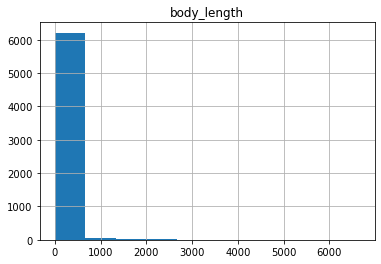

In [5]:
# Check the distribution of the post lengths. Are there very long posts that we might want to remove from the dataset?
df1.hist(column = 'body_length')

In [6]:
# Summary statistics for post body length
df1['body_length'].describe()

count    6336.000000
mean      139.889205
std       290.902798
min         2.000000
25%        42.000000
50%        78.000000
75%       144.000000
max      6653.000000
Name: body_length, dtype: float64

<AxesSubplot:xlabel='body_length'>

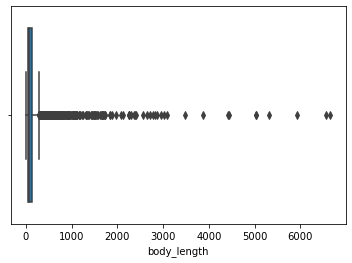

In [7]:
sns.boxplot(x=df1['body_length'])

**Conclusion**: The outliers may be a problem

### Check if the post length distributions are different between the subreddits

In [8]:
# Get the distribution for the vegan subreddit
df_vegan = df1[df1['subreddit'] == 'vegan']
df_vegan['body_length'].describe()

count    1893.000000
mean      142.099842
std       211.776135
min         2.000000
25%        47.000000
50%        91.000000
75%       178.000000
max      6562.000000
Name: body_length, dtype: float64

In [9]:
# Get the distribution for the Cooking subreddit
df_Cooking = df1[df1['subreddit'] == 'Cooking']
df_Cooking['body_length'].describe()

count    4443.000000
mean      138.947333
std       318.719602
min         2.000000
25%        41.000000
50%        73.000000
75%       133.000000
max      6653.000000
Name: body_length, dtype: float64

**Conclusion**: The cooking subreddit has higher variation, but the mean body lengths are similar

In [10]:
# check the shape before cleaning
df1.shape

(6336, 10)

In [11]:
# Text cleaning function from 
# https://medium.com/analytics-vidhya/text-cleaning-in-natural-language-processing-nlp-bea2c27035a6
def clean_text(col_w_text):
    # replace html characters with space
    col_w_text= [re.sub('<.*?>', ' ', t) for t in col_w_text]  
    #remove punctuation
    col_w_text = [t.translate(str.maketrans(' ',' ',string.punctuation)) for t in col_w_text]
    # keep only letters and numbers
    col_w_text = [re.sub('[^a-zA-Z]',' ',t) for t in col_w_text] 
    # replace newline with space
    col_w_text = [re.sub("\n"," ",t) for t in col_w_text]
    # convert to lowercase
    col_w_text = [t.lower() for t in col_w_text]
    # split and join the words
    col_w_text = [' '.join(t.split()) for t in col_w_text]
    
    return col_w_text

In [12]:
# clean the title column
df1['title'] = clean_text(df1['title'])

In [13]:
# clean the body column
df1['body'] = clean_text(df1['body'])

In [14]:
# update the length of the body text. The length is 1 for an empty column.
df1['body_length'] = [len(x.split(' ')) for x in df1.body]

In [15]:
# Remove any empty body columns created during cleaning
df1 = df1[df1.body_length != 1]
df1.head()

,id,title,body,num_comments,upvotes,time_posted,time_now,time_delta,subreddit,body_length
0,jvq4pp,psa if you hate peta thats because a right win...,a huge smear campaign started by peta kills an...,901,2829,1.605605e+09,2021-05-16 11:36:28.594755,180 days 02:07:37.594756,vegan,280
1,114zvn,i was a vegan for several months until this pa...,they said that the goats ate only fresh goat f...,239,0,1.349707e+09,2021-05-16 11:36:28.594762,3141 days 21:06:08.594763,vegan,300
2,lenglo,why are vegan subs so cowardly when it comes t...,i m pretty sure i was just quietly banned edit...,75,3,1.612708e+09,2021-05-16 11:36:28.594795,97 days 21:07:42.594795,vegan,321
3,ixiq4p,white veganism and why its problematic,personally im a person of color and it frustra...,64,0,1.600759e+09,2021-05-16 11:36:28.594806,236 days 04:18:37.594806,vegan,382
4,giowc5,tired of cigarette smokers calling themselves ...,you literally can t smoke cigarettes and be a ...,14,1,1.589333e+09,2021-05-16 11:36:28.594824,368 days 10:20:15.594824,vegan,93


In [16]:
df1.shape

(6334, 10)

**Conclusion**: only removed 2 rows

In [17]:
# get the length of the title text
df1['title_length'] = [len(x.split(' ')) for x in df1.title]

In [18]:
# Remove any empty title columns
df1 = df1[df1.title_length != 1]
df1.head()

,id,title,body,num_comments,upvotes,time_posted,time_now,time_delta,subreddit,body_length,title_length
0,jvq4pp,psa if you hate peta thats because a right win...,a huge smear campaign started by peta kills an...,901,2829,1.605605e+09,2021-05-16 11:36:28.594755,180 days 02:07:37.594756,vegan,280,16
1,114zvn,i was a vegan for several months until this pa...,they said that the goats ate only fresh goat f...,239,0,1.349707e+09,2021-05-16 11:36:28.594762,3141 days 21:06:08.594763,vegan,300,38
2,lenglo,why are vegan subs so cowardly when it comes t...,i m pretty sure i was just quietly banned edit...,75,3,1.612708e+09,2021-05-16 11:36:28.594795,97 days 21:07:42.594795,vegan,321,13
3,ixiq4p,white veganism and why its problematic,personally im a person of color and it frustra...,64,0,1.600759e+09,2021-05-16 11:36:28.594806,236 days 04:18:37.594806,vegan,382,6
4,giowc5,tired of cigarette smokers calling themselves ...,you literally can t smoke cigarettes and be a ...,14,1,1.589333e+09,2021-05-16 11:36:28.594824,368 days 10:20:15.594824,vegan,93,7


In [19]:
df1.shape

(6271, 11)

**Conclusion**: only removed about 100 rows. I still have enough data for NLP.

In [20]:
# Check the distribution between subreddits
df1['subreddit'].value_counts()

Cooking    4412
vegan      1859
Name: subreddit, dtype: int64

**Conclusion**: There is still enough data in each subreddit to analyze. r/Cooking has many more posts.

## Initial examination of what words are relevant in the body text

In [21]:
# Initialize and fit TF-IDF vectorizer
tvec_body = TfidfVectorizer(stop_words = 'english',
                      max_features = 150,      
                      max_df = .95,           
                      norm = 'l1')           
                        
tvec_body.fit(df1['body'])

TfidfVectorizer(max_df=0.95, max_features=150, norm='l1', stop_words='english')

In [22]:
# Convert to dataframe and add the subreddit column as the target
df_tvec_body = pd.DataFrame(tvec_body.transform(df1['body']).todense(),
                       columns = tvec_body.get_feature_names())
df_tvec_body['target_sub'] = df1['subreddit']

In [23]:
# Examine some of the top features
df_tvec_body.sort_values('target_sub', ascending = False).head()

,actually,add,animal,animals,bad,beef,best,better,bit,bread,...,want,wanted,water,way,white,work,wrong,year,years,target_sub
0,0.0,0.0,0.043496,0.129545,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.044201,0.048867,0.0,0.043134,vegan
1260,0.0,0.0,0.000000,0.629350,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,vegan
1272,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,vegan
1271,0.0,0.0,0.000000,0.033868,0.0,0.0,0.0,0.0,0.0,0.041447,...,0.025862,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,vegan
1270,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,vegan


## Initial examination of what words are relevant for the title text

In [24]:
# Initialize and fit TF-IDF vectorizer
tvec_title = TfidfVectorizer(stop_words = 'english',
                      max_features = 150,      
                      max_df = .95,           
                      norm = 'l1')           
                        
tvec_title.fit(df1['title'])

TfidfVectorizer(max_df=0.95, max_features=150, norm='l1', stop_words='english')

In [25]:
# Convert to dataframe and add the subreddit column as the target
df_tvec_title = pd.DataFrame(tvec_title.transform(df1['title']).todense(),
                       columns = tvec_title.get_feature_names())
df_tvec_title['target_sub'] = df1['subreddit']

In [26]:
df_tvec_title.sort_values('target_sub', ascending = True).head()

,actually,advice,animal,animals,bad,beef,best,better,black,bought,...,water,way,week,whats,white,work,wrong,year,years,target_sub
3142,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cooking
4042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cooking
4041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cooking
4040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cooking
4039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cooking


### Conclusions from above work: 
- Need to use stemming or lemmatizing to narrow down features. Consolodate animal/animals, want/wanted, etc
- For TF-IDF, the title and body features are quite similar.

In [27]:
# load spacy core language model
lang_mod = spacy.load("en_core_web_sm")

In [28]:
# Stem body text with the Porter Stemmer
stemmer = PorterStemmer()

#Split, process, join. Pull out each individual word and join into sentences. List of lists.
df1['stemmed_body'] = [' '.join([stemmer.stem(w.text) for w in lang_mod(t)]) 
                      for t in df1['body']]

In [29]:
# Initialize TF-IDF vectorizer
tvec_body_st = TfidfVectorizer(stop_words = 'english',
                      max_features = 150,      
                      max_df = .95,           
                      norm = 'l1')           
                        
# fit vectorizer
tvec_body_st.fit(df1['stemmed_body'])

# create tfidf matrix
df_tvec_body_st = pd.DataFrame(tvec_body_st.transform(df1['stemmed_body']).todense(),
                  columns = tvec_body_st.get_feature_names())

df_tvec_body_st['target_sub'] = df1['subreddit']

# show df
df_tvec_body_st.sort_values('target_sub', ascending = False)

,actual,ad,add,alway,ani,anim,anyon,anyth,ask,bad,...,wa,want,water,way,week,whi,white,work,year,target_sub
0,0.000000,0.0,0.0,0.000000,0.020025,0.106512,0.000000,0.029252,0.000000,0.0,...,0.055613,0.041624,0.000000,0.0,0.0,0.056799,0.0,0.027303,0.026583,vegan
1260,0.000000,0.0,0.0,0.000000,0.000000,0.125577,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,vegan
1272,0.000000,0.0,0.0,0.000000,0.046865,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,vegan
1271,0.000000,0.0,0.0,0.046361,0.000000,0.021576,0.000000,0.023702,0.025332,0.0,...,0.000000,0.016863,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,vegan
1270,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.080125,0.000000,0.000000,0.0,0.0,0.122751,0.0,0.000000,0.000000,vegan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6108,0.000000,0.0,0.0,0.000000,0.016879,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.078575,0.0,0.0,0.000000,0.0,0.023014,0.000000,NaN
6120,0.000000,0.0,0.0,0.000000,0.066583,0.000000,0.260839,0.000000,0.000000,0.0,...,0.061638,0.069201,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,NaN
6141,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.112965,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,NaN
6200,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.050209,0.0,0.0,0.000000,0.0,0.000000,0.000000,NaN


**Conclusion**: I don't like the result above. It is producing too many features that cannot be interpreted, like ad, ani, wa, whi. Try lemmatization instead.

In [30]:
lemmatizer = WordNetLemmatizer()
tokenizer = WhitespaceTokenizer()

In [31]:
# Function to lemmatize text
# Referred to https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells
# Need to tokenize to create words, then lemmatize
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)])

In [32]:
# Lemmatize the body column
df1['lemmatized_body'] = df1['body'].apply(lemmatize_text)

In [33]:
df1.head(40)

,id,title,body,num_comments,upvotes,time_posted,time_now,time_delta,subreddit,body_length,title_length,stemmed_body,lemmatized_body
0,jvq4pp,psa if you hate peta thats because a right win...,a huge smear campaign started by peta kills an...,901,2829,1.605605e+09,2021-05-16 11:36:28.594755,180 days 02:07:37.594756,vegan,280,16,a huge smear campaign start by peta kill anim ...,a huge smear campaign started by peta kill ani...
1,114zvn,i was a vegan for several months until this pa...,they said that the goats ate only fresh goat f...,239,0,1.349707e+09,2021-05-16 11:36:28.594762,3141 days 21:06:08.594763,vegan,300,38,they said that the goat ate onli fresh goat fe...,they said that the goat ate only fresh goat fe...
2,lenglo,why are vegan subs so cowardly when it comes t...,i m pretty sure i was just quietly banned edit...,75,3,1.612708e+09,2021-05-16 11:36:28.594795,97 days 21:07:42.594795,vegan,321,13,i m pretti sure i wa just quietli ban edit so ...,i m pretty sure i wa just quietly banned edit ...
3,ixiq4p,white veganism and why its problematic,personally im a person of color and it frustra...,64,0,1.600759e+09,2021-05-16 11:36:28.594806,236 days 04:18:37.594806,vegan,382,6,person i m a person of color and it frustrat m...,personally im a person of color and it frustra...
4,giowc5,tired of cigarette smokers calling themselves ...,you literally can t smoke cigarettes and be a ...,14,1,1.589333e+09,2021-05-16 11:36:28.594824,368 days 10:20:15.594824,vegan,93,7,you liter can t smoke cigarett and be a vegan ...,you literally can t smoke cigarette and be a v...
5,2g2aa5,i am ashamed of you rvegan,i know weve all witnessed provegan comments ge...,104,24,1.410399e+09,2021-05-16 11:36:28.594842,2439 days 10:00:42.594842,vegan,142,6,i know we ve all wit provegan comment get down...,i know weve all witnessed provegan comment get...
6,3ipyth,i have zero patience for vegetarians that aren...,look i know weve all been there none of us for...,56,0,1.440766e+09,2021-05-16 11:36:28.594845,2087 days 22:41:52.594846,vegan,227,23,look i know we ve all been there none of us fo...,look i know weve all been there none of u for ...
7,b7cb8c,im a trump supporter and a vegan we exist,its no secret that vegans generally lean to th...,61,0,1.553959e+09,2021-05-16 11:36:28.594849,777 days 20:25:48.594849,vegan,386,9,it no secret that vegan gener lean to the left...,it no secret that vegan generally lean to the ...
8,egl3u9,im a meat eater and id like to say that i admi...,even though i didnt commit to the vegan lifest...,43,0,1.577502e+09,2021-05-16 11:36:28.594887,505 days 08:43:23.594888,vegan,46,16,even though i did nt commit to the vegan lifes...,even though i didnt commit to the vegan lifest...
9,6rrvbg,can we please just stop with the political pos...,please stop trying to represent a politically ...,31,7,1.501941e+09,2021-05-16 11:36:28.594894,1379 days 21:40:37.594895,vegan,134,10,pleas stop tri to repres a polit divers commun...,please stop trying to represent a politically ...


In [34]:
# Initialize TF-IDF vectorizer
tvec_body_lem = TfidfVectorizer(stop_words = 'english',
                      max_features = 150,      
                      max_df = .95,           
                      norm = 'l1')           
                        
# fit vectorizer
tvec_body_lem.fit(df1['lemmatized_body'])

# create tfidf matrix
df_tvec_body_lem = pd.DataFrame(tvec_body_lem.transform(df1['lemmatized_body']).todense(),
                  columns = tvec_body_lem.get_feature_names())

df_tvec_body_lem['target_sub'] = df1['subreddit']

# show df
df_tvec_body_lem.sort_values('target_sub', ascending = False)

,actually,add,animal,bad,beef,best,better,bit,bread,butter,...,wa,want,wanted,water,way,week,white,work,year,target_sub
0,0.000000,0.0,0.141711,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,...,0.074418,0.059729,0.000000,0.00000,0.0,0.0,0.0,0.038721,0.035279,vegan
1260,0.000000,0.0,0.236910,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,vegan
1272,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,vegan
1271,0.000000,0.0,0.028049,0.0,0.0,0.0,0.0,0.000000,0.0382,0.0,...,0.000000,0.023644,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,vegan
1270,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,...,0.093957,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,vegan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6108,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,...,0.000000,0.000000,0.000000,0.09222,0.0,0.0,0.0,0.000000,0.000000,NaN
6120,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,...,0.128856,0.000000,0.231199,0.00000,0.0,0.0,0.0,0.000000,0.000000,NaN
6141,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,NaN
6200,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.050707,0.0000,0.0,...,0.000000,0.000000,0.000000,0.05272,0.0,0.0,0.0,0.000000,0.000000,NaN


**Conclusion**: Lemmatizing had some value in reducing duplicate features and produced results that can be interpreted. I will use it for modeling

## Experiment with Count Vectorizing

In [35]:
# Initialize and fit count vectorizer for title text. Remove stop words.
cvec_title = CountVectorizer(stop_words = 'english')
cvec_title.fit(df1['title'])

CountVectorizer(stop_words='english')

In [36]:
# Put into dataframe and append target value
df_cv_1 = pd.DataFrame(cvec_title.transform(df1['title']).todense(),             
                  columns = cvec_title.get_feature_names())
df_cv_1.T.sort_values(0, ascending = False).head(20)

,0,1,2,3,4,5,6,7,8,9,...,6261,6262,6263,6264,6265,6266,6267,6268,6269,6270
peta,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
thats,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hate,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
groups,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lobbying,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
propaganda,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lied,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
winged,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
right,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
psa,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Initialize and fit count vectorizer for body text. Remove stop words.
cvec_body = CountVectorizer(stop_words = 'english')
cvec_body.fit(df1['body'])

CountVectorizer(stop_words='english')

In [38]:
# Put into dataframe and append target value
df_cv_2 = pd.DataFrame(cvec_body.transform(df1['body']).todense(),             
                  columns = cvec_body.get_feature_names())
df_cv_2.T.sort_values(0, ascending = False).head(20)

,0,1,2,3,4,5,6,7,8,9,...,6261,6262,6263,6264,6265,6266,6267,6268,6269,6270
peta,13,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
animals,3,1,0,3,3,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
nokill,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dog,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
shelters,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sick,2,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
youre,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wants,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
thats,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
say,2,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Explore if removing selected columns/features from count vectorized data is important in this case

In [39]:
# Double check structure of df_cv_2
df_cv_2.head()

,aa,aaa,aaaaaand,aaaaah,aaabag,aaabaghttpswwwyoutubecomwatchv,aaabaghttpswwwyoutubecomwatchvddqvam,aaajm,aaand,aaas,...,zwillings,zwrbzelkpuewmjm,zwrbzelkpuewnzg,zxrk,zy,zyb,zyk,zylissgarlicpeelerjpg,zyph,zyr
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
# Check shape of original dataframe
df_cv_2.shape

(6271, 30664)

In [41]:
# create a target column
df_cv_2['target_sub'] = df1['subreddit']

In [42]:
df_cv_2.shape

(6271, 30665)

In [43]:
# The most common features in the count vectorized data seem to be words that would be in the vegan subreddit
# and not the Cooking subreddit. Create a new dataframe with suspicious words. Compare to nonsuspicious word "food".
df_suspicious = df_cv_2[['peta', 'nokill', 'sick', 'shelter', 'group', 'food', 'target_sub']]

In [44]:
df_suspicious.groupby('target_sub').mean()

,peta,nokill,sick,shelter,group,food
target_sub,,,,,,
Cooking,0.000000,0.000000,0.012652,0.000230,0.004831,0.330803
vegan,0.025282,0.002152,0.022055,0.006993,0.029586,0.314685


**Conclusions**: There are outliers in the count vectorized data

## Conclusions from initial analysis:
- Removing some long posts will probably lead to more reliable models, as body text length has outliers. This could affect models on body text. Body text has more data and is probably better for modeling.
- Using TF-IDF for modeling is probably better
- Count vectorizing produces a lot of interesting words, but many of them are outliers in that they are mostly in one subreddit. Using count vectorizing for visualization outside of modeling makes sense.

## Analysis of data on the most common words in what will be the positive class

In [45]:
# Check the shape of the title data
df_cv_1.shape

(6271, 7556)

In [46]:
# Create a target column for the title data
df_cv_1['target_sub'] = df1['subreddit']

In [47]:
# Conclusion: one column was added for the target column
df_cv_1.shape

(6271, 7557)

### Create dataframes for the title and body data for rows in the vegan subreddit

In [48]:
df_cv1_vegan = df_cv_1[df_cv_1['target_sub'] == 'vegan']

In [49]:
df_cv1_vegan.head(20)

,aam,abalonerecipe,abandoned,abdominal,abilities,abillion,able,abomination,aboriginal,abortion,...,zero,zine,ziploc,ziti,zojirushi,zombie,zoos,zucchini,zwilling,target_sub
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,vegan
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,vegan
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,vegan
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,vegan
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,vegan
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,vegan
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,vegan
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,vegan
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,vegan
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,vegan


In [50]:
df_cv2_vegan = df_cv_2[df_cv_2['target_sub'] == 'vegan']

### Most common words in title data for vegan subreddit

In [51]:
# drop non-numeric column to graph
df_cv1_vegan_graph = df_cv1_vegan.drop(columns=['target_sub'])

<AxesSubplot:>

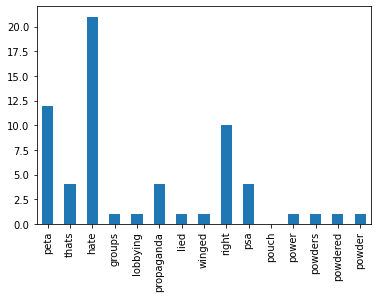

In [52]:
top_cv1_vegan = df_cv1_vegan_graph.T.sort_values(0, ascending=False).head(15).T
top_cv1_vegan.sum().plot(kind='bar')

### Most common words in body data for vegan subreddit

In [53]:
# drop non-numeric column to graph
df_cv2_vegan_graph = df_cv2_vegan.drop(columns=['target_sub'])

<AxesSubplot:>

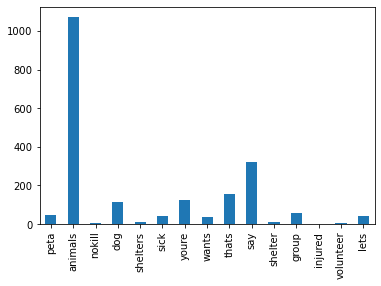

In [54]:
top_cv2_vegan = df_cv2_vegan_graph.T.sort_values(0, ascending=False).head(15).T
top_cv2_vegan.sum().plot(kind='bar')